## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def add_UE_share_constraints(
    scen,
    path_UE_share_input,
    ssp="SSP2",
    start_year=None,
    calibration_year=None,
    period_interpol=4,
    clean_relations=False,
    verbose=False,
):
    """Add share constraints for end-use technologies.

    The purpose of this script is to add share constraints for the end-use
    sectors, thereby replacing any exisiting relation based share constraints
    in the process.
    The share constraint parametrization is read from an Excel-file and has
    been setup so that it can be applied to all five SSPs. Some constraints
    are applicable for multiple SSPs and nodes.
    The share constraints are parameterized so that the total to which the
    share is applied is derived based on a level/commodity and the
    technologies contributing to a share are specified individually. Shares
    with a value of 1. are not added to the model. In the process of adding
    the share constraints, a check is undertaken to ensure that the share
    constraint values do do not violate the calibrated baseyear shares. If
    they do, then the baseyear share value is interpolated, so that the
    target-share value as specied in the Excel-file are gradually achieved
    over time.

    Parameters
    ----------
    scen : :class:`message_ix.Scenario`
        scenario to which changes should be applies
    ssp : string
        specify for which SSP the parameters should be added
    start_year : int
        specify the year as of which constraints should be added;
        If None, then `firstmodelyear`
    calibration_year : int
        specify the last year for data has been calibrated
        If None, the `firstmodelyear` -1
    period_intpol : int (default=4)
        the number of time periods (not years) over which deviations
        converge
    clean_relations : boolean
        option whether to entirely remove all relation based UE share
        constraints.
    verbose : boolean (default=False)
        option whether to primnt onscreen messages.
    """

    # Remove all existing UE_ growth constraints
    if clean_relations is True:
        with scen.transact("Remove UE relations"):
            remove_rel = [r for r in scen.set("relation") if r.find("UE_") >= 0]
            scen.remove_set("relation", remove_rel)

            remove_tec = [t for t in scen.set("technology") if t.find("useful_") >= 0]
            scen.remove_set("technology", remove_tec)

    # Retrieve share constraint input data
    data = pd.read_excel(path_UE_share_input)

    # Retrieve list of scenario years
    years = scen.set("year").tolist()

    # If start_year is None, set to `firstmodelyear`
    if start_year is None:
        start_year = scen.firstmodelyear

    # If calibration_year is None, set to `firstmodelyear`
    if calibration_year is None:
        calibration_year = years[years.index(scen.firstmodelyear) - 1]

    # Ensure that the data is relevant for the current SSP
    data_gen = data.loc[data.SSP == "all"]
    data_ssp = data.loc[data.SSP == ssp]

    for i in data_ssp.index:
        if data_ssp.loc[i, "node"] == "all":
            data_gen = data_gen.loc[
                ~(data_gen.share_name == data_ssp.loc[i, "share_name"])
            ]
        else:
            data_gen = data_gen.loc[
                ~(
                    (data_gen.share_name == data_ssp.loc[i, "share_name"])
                    & (data_gen.node == data_ssp.loc[i, "node"])
                )
            ]
    data = pd.concat([data_ssp, data_gen]).reset_index().drop("index", axis=1)

    # Start workflow to add parameters
    with scen.transact(""):
        for i in data.index:
            row = data.iloc[i]

            if row.share_name in scen.set("relation").tolist():
                if verbose:
                    print(f"Removing relation {row.share_name}")
                scen.remove_set("relation", row.share_name)

            # Skip if share is 100%
            if row.target_value == 1:
                continue

            # Derive individual elements required for parametrization
            # Assign share names
            share_name = row.share_name
            if share_name not in scen.set("shares").tolist():
                if verbose:
                    print(f"Adding share {row.share_name}")
                scen.add_set("shares", share_name)

            # Derive names of share total and share
            share_name_total = f"{share_name}_total"
            share_name_share = f"{share_name}_share"

            # Assign technologies
            tec_list_share = row.share_tec.split(",")

            # Ensure that the output of the technologies have the same output
            # as defined for "commodity" and "useful"
            check_output = scen.par("output", filters={"technology": tec_list_share})[
                ["commodity", "level"]
            ].drop_duplicates()
            assert row.commodity in check_output.commodity.tolist()
            assert row.level in check_output.level.tolist()

            # Retrieve all technologies which have an outout onto the desired
            # "commodity" and "level"
            output = scen.par(
                "output", filters={"level": row.level, "commodity": row.commodity}
            )
            tec_list_total = output.technology.unique().tolist()

            # Add technologies to new type_tec
            for tec in tec_list_total:
                cur_type_tec = scen.set(
                    "cat_tec", filters={"type_tec": share_name_total}
                ).technology.tolist()
                if tec not in cur_type_tec:
                    scen.add_cat("technology", share_name_total, tec)

            for tec in tec_list_share:
                cur_type_tec = scen.set(
                    "cat_tec", filters={"type_tec": share_name_share}
                ).technology.tolist()
                if tec not in cur_type_tec:
                    scen.add_cat("technology", share_name_share, tec)

            # Define nodes, if "all" then all are retrieved from the output
            # for which the target share technology is available
            if row.node == "all":
                nodes = output.loc[
                    output.technology.isin(tec_list_share)
                ].node_loc.unique()
            else:
                nodes = [f"R12_{r}" for r in row.node.split(",")]

            # Assign type_tec to map_shares_commodity_total
            for n in nodes:
                df = pd.DataFrame(
                    {
                        "shares": share_name,
                        "node_share": n,
                        "node": n,
                        "type_tec": share_name_total,
                        "mode": output.loc[
                            (output.technology.isin(tec_list_total))
                            & (output.node_loc == n)
                        ]["mode"]
                        .unique()
                        .tolist(),
                        "commodity": row.commodity,
                        "level": row.level,
                    }
                )
                scen.add_set("map_shares_commodity_total", df)

            # Assign type_tec to map_shares_commodity_total
            for n in nodes:
                df = pd.DataFrame(
                    {
                        "shares": share_name,
                        "node_share": n,
                        "node": n,
                        "type_tec": share_name_share,
                        "mode": output.loc[
                            (output.technology.isin(tec_list_share))
                            & (output.node_loc == n)
                        ]["mode"]
                        .unique()
                        .tolist(),
                        "commodity": row.commodity,
                        "level": row.level,
                    }
                )
                scen.add_set("map_shares_commodity_share", df)

            # Derive shares of activity in the calibration_year
            if calibration_year >= scen.firstmodelyear:
                par = "bound_activity_lo"
            else:
                par = "historical_activity"
            act_total = scen.par(
                par,
                filters={
                    "node_loc": nodes,
                    "technology": tec_list_total,
                    "year_act": calibration_year,
                },
            )
            act_total = act_total.groupby(["node_loc"]).sum(numeric_only=True)[
                ["value"]
            ]

            act_share = scen.par(
                "bound_activity_lo",
                filters={
                    "node_loc": nodes,
                    "technology": tec_list_share,
                    "year_act": calibration_year,
                },
            )
            act_share = act_share.groupby(["node_loc"]).sum(numeric_only=True)[
                ["value"]
            ]

            baseyear_share = round((act_share / act_total) * 1000) / 1000
            baseyear_share = baseyear_share.dropna()

            # Create timeseries for values
            share_type = (
                "share_commodity_lo"
                if row.share_type == "lower"
                else "share_commodity_up"
            )

            # If "baseyear" then add timeseries with baseyear values for all years
            if row.target_value == "baseyear":
                for n in nodes:
                    if n not in baseyear_share.index.values:
                        val = 0
                    else:
                        val = baseyear_share.loc[n].value
                    df = pd.DataFrame(
                        {
                            "shares": share_name,
                            "node_share": n,
                            "year_act": [
                                y for y in scen.set("year") if y >= start_year
                            ],
                            "time": "year",
                            "value": val,
                            "unit": "-",
                        }
                    )
                    scen.add_par(share_type, df)

            else:
                for n in nodes:
                    if row.target_value == "TS":
                        # Create timeseries dataframe
                        ts = pd.DataFrame(
                            row[[y for y in row.index if y in years]]
                        ).rename(columns={i: "value"})
                        ts.value = ts.value.astype(float)
                    else:
                        ts = pd.DataFrame(
                            {
                                "year_act": [y for y in years if y >= calibration_year],
                                "value": row.target_value,
                            }
                        ).set_index("year_act")
                    if n not in baseyear_share:
                        baseval = ts.iloc[0].value
                    else:
                        baseval = baseyear_share.loc[n].value
                    # Check if timeseries value is smaller than baseyear_share
                    check = True
                    if row.share_type == "lower":
                        # If lower, check if baseyear share value is smaller
                        # than the target value if it is, then the interpolate
                        # to gradually reduce the share.
                        check = baseval < ts.iloc[0].value
                    elif row.share_type == "upper":
                        # If upper, check if baseyear share value is larger
                        # than the target value if it is, then the interpolate
                        # to gradually increase the share.
                        check = baseval < ts.iloc[0].value
                    if check == False:
                        if calibration_year not in ts.index:
                            ts = pd.concat(
                                [
                                    pd.DataFrame(
                                        {"year": calibration_year, "value": [baseval]}
                                    ).set_index("year"),
                                    ts,
                                ]
                            )
                        else:
                            ts.loc[calibration_year, "value"] = baseval
                        ts.loc[
                            years[
                                years.index(calibration_year)
                                + 1 : years.index(calibration_year)
                                + period_interpol
                            ],
                            "value",
                        ] = np.nan

                        # Interpolate values
                        ts = ts.interpolate(method="index")

                    # Assign the remaining index values
                    ts = (
                        ts.assign(
                            shares=share_name, node_share=n, time="year", unit="-"
                        )
                        .reset_index()
                        .rename(columns={"index": "year_act"})
                    )

                    # Filter out years >= the start_year, so the year as of
                    # which parameters should be added
                    ts = ts.loc[ts.year_act >= start_year]
                    scen.add_par(share_type, ts)


Adding share UE_transport_liquid
it works
SSP5 objective value: 5059633.5
stor scenario: SSP5


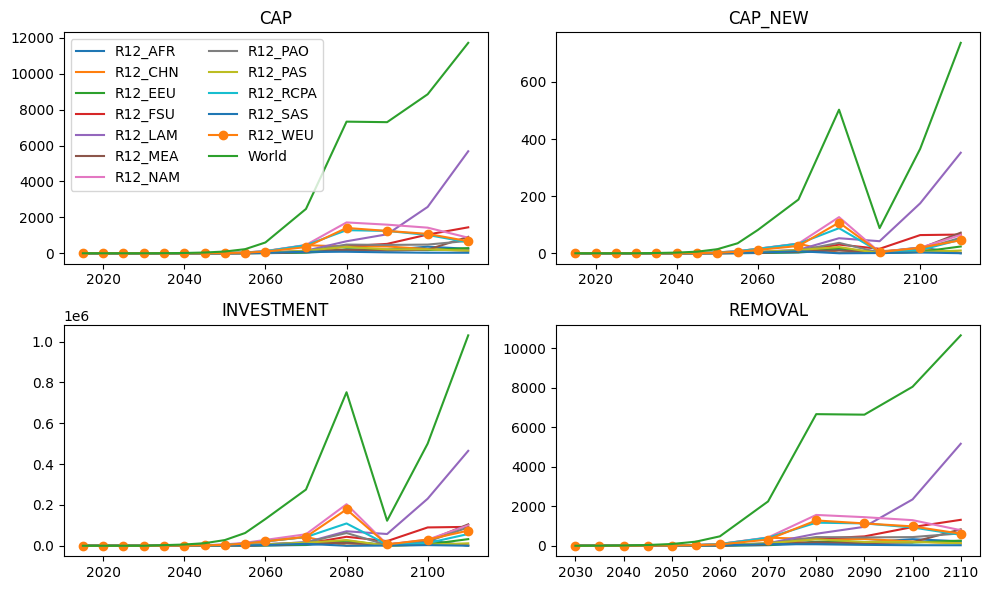

In [3]:
ssps = ["SSP5"]

versions ={"v2":{"co2_rate":30000,
                 "budget":300},
           "v4":{"co2_rate":35000,
                 "budget":-300},
           "v5":{"co2_rate":32000,
                 "budget":-300}
          }


for ssp in ssps:
    mp = ixmp.Platform()

    sbase = message_ix.Scenario(mp, model=f"SSP_{ssp}_v1.0",
                                scenario=f"{ssp} - Low Overshoot") #
    
    s2run = sbase.clone(
        f"SSP_{ssp}_v1.0",
        f"{ssp} - Low Overshoot_Relaxed-CCS-v5",
        keep_solution=False,
    )
    s2run.check_out()
    
    # Relaxing co2 injection rate constraint
    df2rem = s2run.par("bound_activity_up",{
        "technology":"co2_stor_glb"})
    df2add = df2rem.copy()
    df2add["value"] = np.round(32000/3.667,0)
    
    s2run.remove_par("bound_activity_up",df2rem)
    s2run.add_par("bound_activity_up", df2add)  # comment out if want unlimited injection rate
    
    # Relaxing trans1 activity up
    df2rem = s2run.par("bound_activity_up",{
        "technology":"co2_trans1"})
    s2run.remove_par("bound_activity_up",df2rem)
    
    # Removing co2 storage share constraint
    df2rem = s2run.par("share_mode_lo",{
        "technology":"co2_storcumulative"})
    s2run.remove_par("share_mode_lo",df2rem)
    
    
    # updating emission bound
    df2rem = s2run.par("bound_emission",{"node":"World","type_emission":"TCE","type_year":"cumulative"})
    df2add = df2rem.copy()
    df2add["value"] = -300
    
    s2run.remove_par("bound_emission",df2rem)
    s2run.add_par("bound_emission", df2add)
    
    # increasing storage limit
    df2rem = s2run.par("bound_activity_up",{"technology":"co2_storcumulative"})
    df2add = df2rem.copy()
    df2add["value"] = df2rem["value"].mul(100)
    
    s2run.remove_par("bound_activity_up",df2rem)
    #s2run.add_par("bound_activity_up", df2add)
    
    # Remove transport thing
    s2run.remove_set("shares", "UE_transport_fossil_Minimum")
    s2run.add_set("technology", ['meth_fc_trp','meth_ic_trp'])

    s2run.commit(comment=f"{ssp}_1000f all ssp param")

    input_path = "C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs"
    file_name = "/ue_share_constraints.xlsx"
    add_UE_share_constraints(
            s2run, # scenario object
            input_path+file_name, # path
            ssp="SSP5", # SSP-name i.e "LED"
            start_year=2035, # the year as of which a constraint should be added, best this is the firstmodelyear for your case
            calibration_year=2020, # 2020
            clean_relations=False, # set to False
            verbose=True, # set to True
        )
    
    with s2run.transact(""):
        s2run.add_set("balance_equality", ["bic_co2", "secondary"])
        s2run.add_set("balance_equality", ["fic_co2", "secondary"])
        s2run.add_set("balance_equality", ["dac_co2", "secondary"])
        s2run.add_set("balance_equality", ["methanol", "final_material"])
        s2run.add_set("balance_equality", ["HVC", "demand"])
        s2run.add_set("balance_equality", ["HVC", "export"])
        s2run.add_set("balance_equality", ["HVC", "import"])
        s2run.add_set("balance_equality", ["ethylene", "final_material"])
        s2run.add_set("balance_equality", ["propylene", "final_material"])
        s2run.add_set("balance_equality", ["BTX", "final_material"])
    print("it works")

    
    s2run.solve(solve_options={'scaind': '1','lpmethod': '4'})
    print(ssp, "objective value:", s2run.var("OBJ")["lvl"])

    # Get Report
    print("stor scenario:", ssp)
    scenariotec = ['dac_lt','dac_hte','dac_htg',]
    scenario_report = get_report(s2run,scenariotec)

    s2run.set_as_default()        
    
    # CLOSE CONNECTION
    mp.close_db()


In [4]:
colors = {"SSP_SSP2_v1.0":"tab:orange","SSP_SSP5_v1.0":"tab:purple","SSP_SSP4_v1.0":"tab:blue"}

setups = {#'SSP_SSP2_v1.0':'SSP2 - Low Overshoot_Relaxed-CCS-v2',
          #'SSP_SSP4_v1.0':'SSP4 - Low Overshoot_Relaxed-CCS-v2',
          #'SSP_SSP5_v1.0':'SSP5 - Low Overshoot_Relaxed-CCS-v2',
          'SSP_SSP5_v1.0':'SSP5 - Low Overshoot_Relaxed-CCS-v5',
          }